In [631]:
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels.stats.multitest as smm
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(color_codes=True)

In [632]:
def print_error_rates(test, start):
    print("True: %d" % sum([t for t in test[start:900]]))
    print("False: %d" % sum([not t for t in test[start:900]]))

    print("True: %d" % sum([t for t in test[900:]]))
    print("False: %d" % sum([not t for t in test[900:]]))
    
    print("Type I error rate (false positives): %.4f" % (sum([not t for t in test[start:900+start]]) / 900.))
    print("Type II error rate (false negatives): %.4f" % (sum([t for t in test[900+start:]]) / 100.))

Here we want to have a first look on the multiple correction problem on a set of 1000 simulated experiments. We generate 1000 random variables where 900 random variables are from standard normal distribution with mean 0 and 100 - with the mean 3. We use the random normals in such a way that we’ll know what the result of each hypothesis test should be.

### Simulated data

Here we test a simulated hypothesis based on the data drown from standard normal distribution.

<b>H0</b>: value of x is not different from 0

<b>H1</b>: value of x is larger than 0

The first 900 observations should fail to reject the null hypothesis: they are drawn from a standard normal distribution (mean 0) and any 2 difference between the observed value and 0 is just due to chance. 

The last 100 observations should reject the null hypothesis: the difference between these values and 0 is not due to
chance alone.

In [633]:
numtests = 1000
alpha = 0.0001

np.random.seed(42)

### Problem

In many science applications, the alpha level, or Type I error rate, is set to 0.05. This means that the researcher is willing to commit a Type I error 5% of the time. But when we move to a problem of multiple comparisons, the alpha level is no longer valid.
For example, if we use the conventional significance level of 0.05 for 1000 tests, then there is 100% chance that we reject at least one true null hypothesis.

* alpha : probability of rejecting true hypothesis for one test
* (1 - alpha) : probability of not rejecting true hypothesis for one test
* (1 - alpha)^m : probability of not rejecting m true hypothesis (we have m tests)
* (1 - (1 - alpha)^m) : probability of rejecting at least one out of m true null hypotheses

In [634]:
1-(1-alpha)**numtests

0.09516710644144377

In [635]:
data1= st.norm.rvs(0, 1, size=900)
data2 = st.norm.rvs(3, 1, size=100)
data = np.concatenate((data1, data2), axis=0)
print(data[:10])

[ 0.49671415 -0.1382643   0.64768854  1.52302986 -0.23415337 -0.23413696
  1.57921282  0.76743473 -0.46947439  0.54256004]


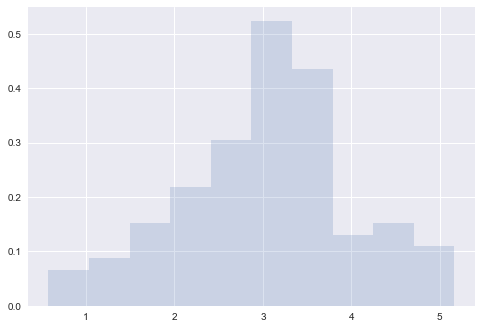

In [636]:
fig, ax = plt.subplots(1, 1)
ax.hist(data2, normed=True, histtype='stepfilled', alpha=0.2)
plt.show()

In [637]:
prob = st.norm.pdf(data)
print(prob[:10])

[ 0.35264231  0.39514715  0.32345711  0.12508666  0.38815426  0.38815575
  0.11464727  0.29718021  0.35731354  0.34434052]


In [638]:
test = prob > alpha
print(test[:100])

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]


In [639]:
print_error_rates(test, 0)

True: 900
False: 0
True: 85
False: 15
Type I error rate (false positives): 0.0000
Type II error rate (false negatives): 0.8500


### Controlling FWER and FDR

In the world of multiple testing, the Type I error rate might refer to one of two things: the Family-Wise Error Rate (FWER) or the False Discovery Rate (FDR).

FWER is the probability that we reject at least one true null hypothesis. FDR is the expected fraction of false rejections out of all rejections and zero if there are no rejections.

### Bonferroni correction. Family-wise error rate (FWER)

1. Denote by $p_{i}$ the p-value for testing $H_{i}$
2. Reject $H_{i}$ if $p_{i} \le \frac{\alpha}{m}$

In [640]:
bonf_test = prob > alpha/numtests
print("Alpha: %.5f"%(alpha/numtests))

Alpha: 0.00000


In [641]:
# from statsmodels.stats.multitest
# rej, pval_corr = smm.multipletests(prob, alpha=0.05, method='b')[:2]

In [642]:
print_error_rates(bonf_test, 0)

True: 900
False: 0
True: 100
False: 0
Type I error rate (false positives): 0.0000
Type II error rate (false negatives): 1.0000


We decreased the <b>Type I error (false positives)</b> but increased the <b>Type II error (false negatives)</b>.

Now we have 0 false positive rate, meaning we don't have false positives at all, but the value of false negatives is quite high, meaning we falsly accepted many null hypothesis (x's are close to zero when they are actually not).

The Bonferroni correction is appropriate when a single false positive in a set of tests would be a problem. It is mainly useful when there are a fairly small number of multiple comparisons and you're looking for one or two that might be significant. However, if you have a large number of multiple comparisons and you're looking for many that might be significant, the Bonferroni correction may lead to a very high rate of false negatives.

This correction works in the worst-case scenario that all tests are independent. But in most cases, tests are not independent. That is, if your treatment moves outcome A, it probably moves outcome B too, at least a little. But it does not requires for tests to be independent.

### Sidak correction (FWER)

1. Testing each hypothesis at level $\alpha_{SID}=1-(1-\alpha )^\frac{1}{m}$ is Sidak's multiple testing procedure.
2. This procedure is more powerful than Bonferroni but the gain is small.
3. This procedure can fail to control the FWER when the tests are negatively dependent.

In [643]:
p_val_corrected = (1 - (1 - prob)**(numtests)) > alpha
print_error_rates(p_val_corrected, 0)

True: 900
False: 0
True: 100
False: 0
Type I error rate (false positives): 0.0000
Type II error rate (false negatives): 1.0000


In [644]:
# with stat package
rej_sidak, pval_corr_sidak = smm.multipletests(prob, alpha=alpha, method='s')[:2]
accept_sidak = [not i for i in rej_sidak] 
print_error_rates(accept_sidak, 0)

True: 900
False: 0
True: 100
False: 0
Type I error rate (false positives): 0.0000
Type II error rate (false negatives): 1.0000


The Sidak method assumes that each comparison is independent of the others. If there is no such assumption, the Bonferroni method should be used instead.

### Simes-Hochberg (FWER)

Simes-Hochberg is a step-up method that uses a Bonferroni correction at each step similar to Holm's method. This test is valid under independence and under some forms of positive dependence of p-values. Simes-Hochberg is more powerful than Holm's method under independence.

In [645]:
rej_simes, pval_corr_simes = smm.multipletests(prob, alpha=alpha, method='simes-hochberg')[:2]
accept_simes= [not i for i in rej_simes] 
print_error_rates(accept_simes, 0)

True: 900
False: 0
True: 100
False: 0
Type I error rate (false positives): 0.0000
Type II error rate (false negatives): 1.0000


### Hommel (FWER)

In [646]:
rej_hommel, pval_corr_hommel = smm.multipletests(prob, alpha=alpha, method='hommel')[:2]
accept_hommel= [not i for i in rej_hommel]
print_error_rates(accept_hommel, 0)

True: 900
False: 0
True: 100
False: 0
Type I error rate (false positives): 0.0000
Type II error rate (false negatives): 1.0000


### False discovery rate (FWER). Holm's step-down procedure.

This method doesn't assume the independence of statistical tests, but is more powerful than the other FWER correction methods.
The procedure is:

1. Order p-values in increasing order $P_{(1)} \dots P_{(m)}$ and let the associated hypotheses be $H_{(1)} \dots H_{(m)}$
2. Let k be the minimal index such that :
$$P_{(k)} > \frac{\alpha}{m+1-k}$$
3. Reject the null hypotheses $H_{(1)} \dots H_{(k-1)}$

In [647]:
prob_sorted = np.sort(prob)

fdrtest = None
for i in range(numtests):
    position_value = prob[i] > next(i for i,x in enumerate(prob_sorted) if x == prob[i]) * alpha/numtests
    fdrtest = np.append(fdrtest, position_value)

In [648]:
print_error_rates(fdrtest, 1)

True: 899
False: 0
True: 96
False: 5
Type I error rate (false positives): 0.0000
Type II error rate (false negatives): 0.9500


FWER control exerts a more stringent control over false discovery compared to false discovery rate (FDR) procedures. FWER control limits the probability of at least one false discovery, whereas FDR control limits (in a loose sense) the expected proportion of false discoveries. Thus, FDR procedures have greater power at the cost of increased rates of type I errors, i.e., rejecting null hypotheses that are actually true.

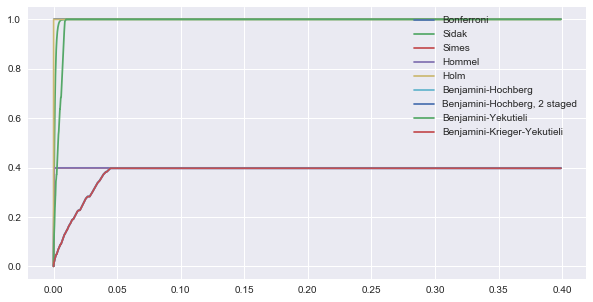

In [649]:
plt.figure(figsize=(10,5))
#plt.axis([0, 0.1, 0, 1.3])
plt.plot(np.sort(prob), np.sort(bonf_test), label='Bonferroni')
plt.plot(np.sort(prob), np.sort(pval_corr_sidak), label='Sidak')
plt.plot(np.sort(prob), np.sort(pval_corr_simes), label='Simes')
plt.plot(np.sort(prob), np.sort(pval_corr_hommel), label='Hommel')
plt.plot(np.sort(prob), np.sort(fdrtest[1:]), label='Holm')
plt.plot(np.sort(prob), np.sort(pval_corr_bh_nn), label='Benjamini-Hochberg')
plt.plot(np.sort(prob), np.sort(pval_corr_bn_nn_2), label='Benjamini-Hochberg, 2 staged')
plt.plot(np.sort(prob), np.sort(pval_corr_by_n), label='Benjamini-Yekutieli')
plt.plot(np.sort(prob), np.sort(pval_corr_bky), label='Benjamini-Krieger-Yekutieli')
plt.legend(loc='upper right')
plt.show()


### Benjamini-Hochberg (FDR)

fdr_bh is the step-up procedure by Benjamini and Hochberg (1995) that controls the FDR under independence and is robust to some form of positive dependence of the p-values. 

In [650]:
rej_bh_nn, pval_corr_bh_nn = smm.multipletests(prob, alpha=alpha, method='fdr_bh')[:2]
accept_sidak = [not i for i in rej_bh_nn]
print_error_rates(accept_sidak, 0)

True: 900
False: 0
True: 100
False: 0
Type I error rate (false positives): 0.0000
Type II error rate (false negatives): 1.0000


In [651]:
# two staged
rej_bn_nn_2, pval_corr_bn_nn_2 = smm.multipletests(prob, alpha=alpha, method='fdr_tsbh')[:2]
accept_bh_nn= [not i for i in rej_bn_nn_2] 
print_error_rates(accept_bh_nn, 0)

True: 900
False: 0
True: 100
False: 0
Type I error rate (false positives): 0.0000
Type II error rate (false negatives): 1.0000


### Benjamini-Yekutieli

fdr_by is the step-up procedure by Benjamini and Yekutiely (2001) that controls the FDR also for other forms of dependence including the case when the p-values are negatively correlated.

In [652]:
rej_by_n, pval_corr_by_n = smm.multipletests(prob, alpha=alpha, method='fdr_by')[:2]
accept_by_n= [not i for i in rej_by_n] 
print_error_rates(accept_by_n, 0)

True: 900
False: 0
True: 100
False: 0
Type I error rate (false positives): 0.0000
Type II error rate (false negatives): 1.0000


### Benjamini-Krieger-Yekutieli

This is the adaptive two-staged method that estimates or adjusts to the number of true null hypotheses. fdr_tsbky uses a different corrected alpha in both the first and the second stages, based on Benjamini, Krieger and Yekutieli (2006).

In [653]:
rej_bky, pval_corr_bky = smm.multipletests(prob, alpha=alpha, method='fdr_tsbky')[:2]
accept_bky= [not i for i in rej_bky] 
print_error_rates(accept_bky, 0)

True: 900
False: 0
True: 100
False: 0
Type I error rate (false positives): 0.0000
Type II error rate (false negatives): 1.0000


### Summary table

Type I error and type II error

|alpha|0.0001|0.001|0.01|0.025|0.05|0.1|Type II error|0.0001|0.001|0.01|0.025|0.05|0.1|
|------|------|
|<b>Control Family-wise Error Rate</b>||||||||||||||
|Uncorrected|0|0.0011|0.0044|0.0167|0.0389|0.0900||0.8500|0.7000|0.3400|0.2400|0.1800|0.1000|
|Bonferroni|0|0|0|0|0|0||1.0000|0.9900|0.9500|0.9000|0.8800|0.8500|
|Sidak|0|0|0|0|0|0||1.0000|0.9900|0.9500|0.9000|0.8800|0.8500|
|Simes-Hochberg|0|0|0|0|0|0||1.0000|0.9900|0.9500|0.9000|0.8800|0.8500|
|Hommel|0|0|0|0|0|0||1.0000|0.9900|0.9500|0.9000|0.8800|0.8500|
|<i>Holm</i>|0|0|0.0011|0.0011|<b>0.0033</b>|0.0033||0.9500|0.6900|0.7000|0.6100|<b>0.5</b>|0.3800|
|<b>Control False Discovery Rate</b>||||||||||||||
|<i>Benjamini-Hochberg</i>|0|0|0|0.0011|<b>0.0022</b>|0.0033||1.0000|0.9500|0.8500|0.7000|<b>0.5200</b>|0.3800|
|Benjamini-Yekutieli|0|0|0|0|0|0.0011||1.0000|1.0000|0.9500|0.8900|0.8500|0.8200|
|Benjamini-Krieger-Yekutieli|0|0|0|0.0011|0.0022|0.0033||1.0000|0.9500|0.8500|0.7000|0.5200|0.3800|

All methods here either control the family-wise error rate (FWER) or the false discovery rate (FDR).

From the results above we can notice that <b>Bonferroni</b> method very conservative, but his may have a plus side. If we have two hypothesis: H0: treatment had no effect on control and H1: there was a significant effect of treatement on control we may be more confident to have more false negatives(falsly accepting null hypothesis by saying there were no effect when, in fact, there was) than more false positives(falsly rejecting null hypothesis by saying there were an effect on control when there is none). Obviously, for both ways we lose a chance of improvement, but having more false positives does not leave us at a high risk.
In our experimentation it created a high false positive rate which may affect the decision.

Is it also very simple in implementing and undestanding and does not require independence of tests.

<b>Sidak</b> method is less conservative and less stringent than Bonferroni (but may be very slightly) and exact for tests that are stochastically independent, conservative for tests that are positively dependent, and is liberal for tests that are negatively dependent. But this method is not a good replacement in case you are not sure about the independence or dependence of your statistical tests.

<b>Simes-Hochberg</b> is very similar procedure to Hochberg(RDF) but controls he FWER in the weak sense (under the intersection null hypothesis) when the statistics are independent. But it is not a good replacement to other FWER correction methods.
    
<b>Holm's step-down</b> method  is uniformly more powerful than the classic Bonferroni method.It reduces the false positive rate and do not produce high false negative rate.

Among RDF correction strategies the most common and straigtforward is <b>Benjamini-Hochberg</b> step-up method. It reduces False discovery rate or the proportion of false discoveries among all discoveries and is robust to some form of positive dependence of the p-values. Other RDF methods (<b>Benjamini-Yekutieli, Benjamini-Krieger-Yekutieli</b>) are variations of the above method.
  
Finally:
If we suspect that there are false hypothesis in our set of tests, then the methods that control the FDR are more powerful in rejecting false null hypothesis at the cost of a small increase in a family-wise number of rejected true null hypotheses. Among the FWER controlling procedures Bonferroni is the most simplest but at the same time the most conservative method. Holm's method seem to be the most poverful among FWER controlling methods. 
Among the methods that control the FDR, Benjamini-Hochberg seems to have the best properties.